In [101]:
# IMPORTS

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import matplotlib.patches as mpatches

# TODO: rewrite code so that grid is an instance of a grid class, and the various values are attributes of the instance, and the vectors are like agents moving around the 

In [102]:
# DATA GENERATION

np.random.seed(5)

FROM_DATA = True
RANDOM_SEA = True # If FROM_DATA is True, RANDOM_SEA is irrelevant

if FROM_DATA:
    mat = sp.io.loadmat("olivegrowthprop.mat")
    olive_prop = mat["olivegrowthprop"] # Phi
    H, W = olive_prop.shape # M, N
    sea_mask = olive_prop < 0
    no_grove_mask = olive_prop == 0

else:
    H = 40
    W = 40
    olive_prop = np.random.random([H,W])

    # set random sea cells (olive_prop < 0)
    if RANDOM_SEA:
        sea_perc = 0.25
        sea_mask = np.random.choice([True, False], size=(H,W), p=[sea_perc, 1-sea_perc])
    else:
        sea_mask = np.zeros([H,W], dtype=bool)
        sea_mask[2:10,5:9] = True
    olive_prop[sea_mask] = -9999

    # set random null cells (olive_prop = 0)
    zero_perc = 0.1 # including sea
    zero_mask = np.random.choice([True, False], size=(H,W), p=[zero_perc, 1-zero_perc])
    no_grove_mask = np.logical_and(~sea_mask, zero_mask)
    olive_prop[no_grove_mask] = 0

grove_mask = olive_prop > 0

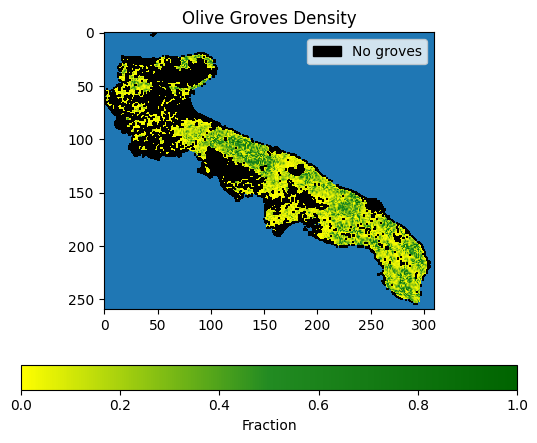

In [103]:
# PLOT DISTRIBUTION OF OLIVE GROVES

PLOT_NO_GROVES = True

cmap_custom = colors.LinearSegmentedColormap.from_list("", ["yellow", "forestgreen", "darkgreen"])
cmap_custom.set_under(color="tab:blue")
norm = colors.Normalize(vmin=0, vmax=1)
images = []

fig, ax = plt.subplots()
images.append(ax.imshow(olive_prop, cmap=cmap_custom))
ax.set_title("Olive Groves Density")

if PLOT_NO_GROVES:
    cmap_custom.set_bad(color="black")  # Black cells have no groves
    zero_patch = mpatches.Patch(color="black", label="No groves")
    masked_data = np.ma.masked_where(olive_prop == 0, olive_prop)

    images.append(ax.imshow(masked_data, cmap=cmap_custom))
    ax.legend(handles=[zero_patch], loc="upper right")

for im in images:
    im.set_norm(norm)

cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal", fraction=0.1)
cbar.set_label("Fraction")

plt.show()

In [104]:
# # DEFINE CONTROL (BUFFER + ERADICATION) ZONE
# # TODO: distinguish between data and generated data
# # TODO: include buffer zone and infected tree detection efficiency 

# BUFFER = False

# if BUFFER:

#     # Remove all trees in the buffer zone
#     xp1, yp1 = [253, 212]
#     xp2, yp2 = [278, 183]

#     BW1 = 20 # 2 bufferwidth1 eradication zone width
#     BW2 = 13 # bufferwidth2 buffer zone width
#     eff = 0.9 # eff control efficiency in the buffer zone
#     timerun = 8 # how many years does the model run for?

#     m = (yp1 - yp2) / (xp1 - xp2)
#     B1 = yp1 - m * xp1
#     B2_erad = B1 - BW1 * np.sqrt(m**2 + 1)
#     B2_rog = B1 - (BW1 + BW2) * np.sqrt(m**2 + 1)

#     for y in range(H):
#         for x in range(W):
#             if y < m*x+B1 and y > m*x+B2_erad and olive_prop[y,x] > 0:
#                 olive_prop[y,x] = 0

#     grove_mask = olive_prop > 0
#     no_grove_mask = olive_prop == 0
    
#     # # Replot olive grove density with control zone   
#     # fig, ax = plt.subplots(figsize=(10, 8))
#     # im = ax.imshow(olive_prop, cmap=cmap_custom, norm=norm)
#     # ax.set_title("Olive Groves Density with Buffer Zone")
#     # cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.1)
#     # cbar.set_label("Fraction")

#     # plt.show()

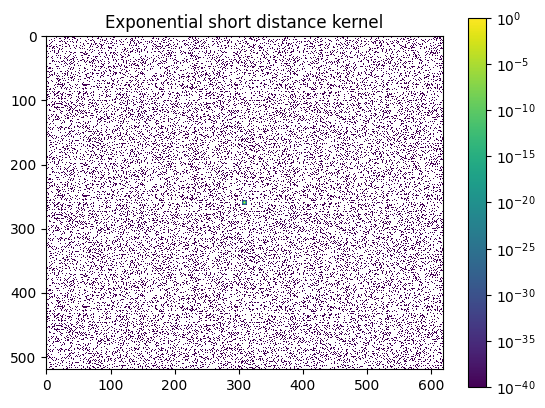

In [105]:
# SHORT DISTANCE KERNEL

KERNEL = "exponential"
beta = 0.1 # 0.1 mean dispersal distance

def exponential_kernel(x, y, beta):
    return np.exp(-(x**2 + y**2)**(1/2) / beta) #/ (2 * np.pi * beta**2)

def gaussian_kernel(x, y, sigma):
    return np.exp(-(x**2 + y**2)/(2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

x = np.linspace(-(W-1), (W-1), 2*W-1)
y = np.linspace(-(H-1), (H-1), 2*H-1)

X, Y = np.meshgrid(x, y)

if KERNEL == "exponential": k = exponential_kernel(X,Y,beta)
elif KERNEL == "gaussian": k = gaussian_kernel(X,Y,beta)

k_threshold = 1e-40
k_min = max(k_threshold, np.min(k))

# PLOT KERNEL

logNorm = colors.LogNorm(vmin=k_min, vmax=1)
norm = colors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots()
im = ax.imshow(k, norm=logNorm)
if KERNEL == "exponential": ax.set_title("Exponential short distance kernel")
elif KERNEL == "gaussian": ax.set_title("Gaussian short distance kernel")
fig.colorbar(im, ax=ax)
plt.show()

In [106]:
def Gompertz_local_growth(U, K, A):
    U = K ** (1 - np.exp(-A)) * (U ** np.exp(-A))
    return U

def adjust_population(U, no_grove_mask, tol):
    U[no_grove_mask] = 0
    U[U < tol] = 0
    return

def short_distance_dispersal(U, kernel):
    U = sp.signal.convolve(U, kernel, mode="same", method="fft")
    return U

def long_distance_dispersal(U, disp_tol, M_max, D, B):
    prob_disp = np.random.random(size=U.shape) * U # dispersal probability for every cell
    disp_cells = np.argwhere(prob_disp > disp_tol) # cells that disperse
    rnd_disp = np.random.randint(1, M_max+1, size=len(disp_cells)) # random number of dispersers per cell

    for disp_cell, n_disp in zip(disp_cells, rnd_disp):
        for i_disp in range(n_disp):
            i = 0
            while True:
                i += 1
                new_cell = disp_cell + np.rint(np.random.normal(0,D,size=2)).astype(np.int32)
                if np.any(new_cell < 0) or np.any(np.array(U.shape - new_cell <= 0)):   continue # Outside grid
                elif np.array_equal(new_cell, disp_cell):                               continue # Same cell
                elif sea_mask[tuple(new_cell)]:                                         continue # Sea
                elif no_grove_mask[tuple(new_cell)]:                                    break    # No grove, OK
                else:
                    U[tuple(new_cell)] += (1 - U[tuple(new_cell)]) * np.exp(-B) # Added the 1-U part to say that the remaining susceptible are infected with probability exp(-B) 
                    break    # OK
    return U

# Rejection sampling mechanism: target and proposal distributions
# def p_target(x, alpha, mu): # target distribution support is [x_min, inf]
#     return x**(-alpha) * np.exp(-mu * x)

# def q_proposal(x, eta):
#     return eta * np.exp(-eta * x)

# Sample from different power law distributions (power law, truncated power law, power law with exponential cutoff)
def sample_power_law(params, x_min=0.1, x_max=None, size=1, sample="power"):
    u = np.random.random(size)

    if sample == "power":
        alpha = params[0]
        x = (1 - u)**(1 / (1 - alpha)) * x_min

    elif sample == "trunc":
        if x_max is None:
            raise Exception("x_max must be provided")
        alpha = params[0]
        x = (u * x_max**(1 - alpha) + (1 - u) * x_min**(1 - alpha))**(1 / (1 - alpha))

    # elif sample == "cutoff":
    #     if len(params) != 3:
    #         raise Exception("alpha, mu, eta must be provided")
    #     if x_max is None:
    #         raise Exception("x_max must be provided")
        
    #     alpha, mu, eta = params
    #     x_linspace = np.linspace(x_min, x_max, 10000)
    #     M = np.max(p_target(x_linspace, alpha, mu) / q_proposal(x_linspace, eta)) # Max is obtained at infinity, so in this case at x=2

    #     x = np.zeros(size)        
    #     for i in range(size):
    #         if i % 100 == 0: print(i)
    #         while True:
    #             x_proposal = np.random.exponential(scale=1/eta) + x_min
    #             if p_target(x_proposal, alpha, mu) / (M * q_proposal(x_proposal, eta)) > u[i]:
    #                 x[i] = x_proposal
    #                 break

    return x

In [107]:
# np.random.seed(123)

# size = 500
# x_min = 0.1
# x_max = 5
# alpha = 2
# mu = 1
# eta = 5
# params = [alpha, mu, eta]

# # samples = sample_power_law(params=params, x_min=x_min, size=size, sample="power")
# # samples = sample_power_law(params=params, x_min=x_min, x_max=x_max, size=size, sample="trunc")
# samples = sample_power_law(params=params, x_min=x_min, x_max=x_max, size=size, sample="cutoff")
# # print(samples)
# # print(len(samples))

# fig, ax = plt.subplots()
# ax.hist(samples, bins=200, density=True, label="Sample")
# plt.yscale("log")
# # plt.xlim(0, 10)
# plt.legend()
# plt.show()

In [108]:
# LEVY FLIGHT DISPERSAL

# TODO: add "scale" parameter for rescaling of random samples

# TODO: Vectors have a certain probability of infecting a susceptible tree.
# TODO: Vectors can be eliminated, according to a certain probability, which depends on preventive measures implemented: weeding, roguing, pesticides, etc.
def levy_flight_dispersal(U, B, n_vectors, vector_positions, params, d_min=0.1, sample="power"):

    if sample == "power":
        d_max = None
    elif sample == "trunc":
        d_max = np.sqrt(np.floor(H/2)**2 + np.floor(W/2)**2); # about half the diagonal

    d_list = sample_power_law(params, x_min=d_min, x_max=d_max, size=n_vectors, sample=sample)

    for i, vector_pos, d in zip(range(n_vectors), vector_positions, d_list):
        y, x = vector_pos

        # If jump is larger than grid, generate new jump
        max_square_dist = np.max([x**2 + y**2,
                                  x**2 + (H - y)**2,
                                  (W - x)**2 + (H - y)**2,
                                  (W - x)**2 + y**2]) - 1 # -1 to account for discreteness of grid
        while d**2 > max_square_dist:
            d = sample_power_law(params, x_min=d_min, x_max=d_max, size=1, sample=sample)

        # j = 0
        while True:
            # j += 1
            theta = np.random.uniform() * 2 * np.pi # random uniform direction
            step_coord = np.rint(d * np.array([np.sin(theta), np.cos(theta)])).astype(np.int32)
            new_vector_pos = vector_pos + step_coord
            if np.any(new_vector_pos < 0) or np.any(np.array(U.shape - new_vector_pos <= 0)):   continue # Outside grid
            elif sea_mask[tuple(new_vector_pos)]:                                               continue # Sea
            elif np.array_equal(new_vector_pos, vector_pos):                                    break    # Same cell, OK
            elif no_grove_mask[tuple(new_vector_pos)]:                                          break    # No grove, OK
            else:
                U[tuple(new_vector_pos)] += (1 - U[tuple(new_vector_pos)]) * np.exp(-B) # Added the 1-U part to say that the remaining susceptible are infected with probability exp(-B) 
                break    # OK
        vector_positions[i] = new_vector_pos
    return U

In [117]:
# SET MODEL PARAMETERS

np.random.seed(13340)

# Gompertz growth function parameters
A = 3 # 3 kp rate of population growth
B = 14.069

# Carrying capacity
a = 0 # relative carrying capacity in non olive plants
K = olive_prop + a * (1 - olive_prop) # CC carrying capacity
K[sea_mask] = 0
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Levy flight
n_vectors = 10000
d_min = 0.1
# TODO: Move parameters SAMPLE and d_max here
alpha = 2
mu = 1
eta = 5
params = [alpha, mu, eta]
SAMPLE = "power"

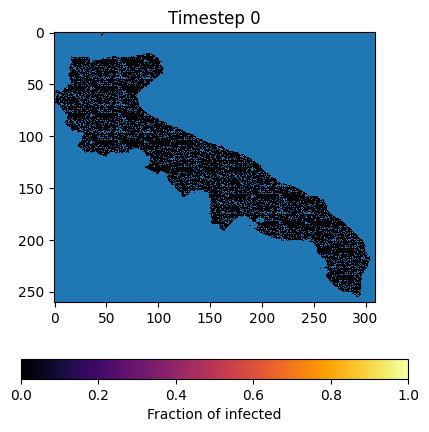

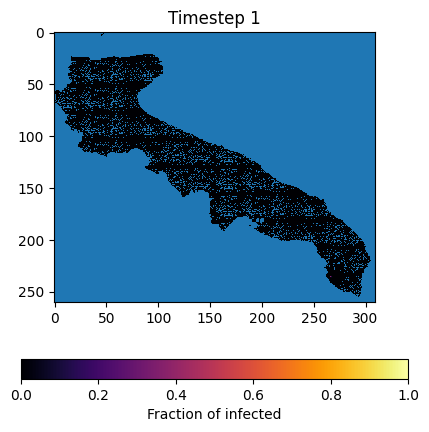

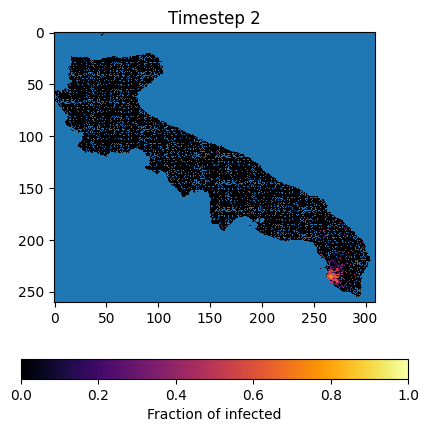

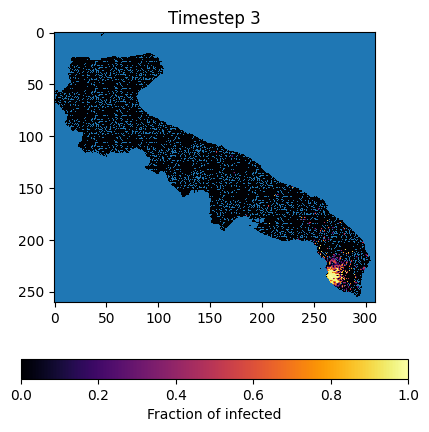

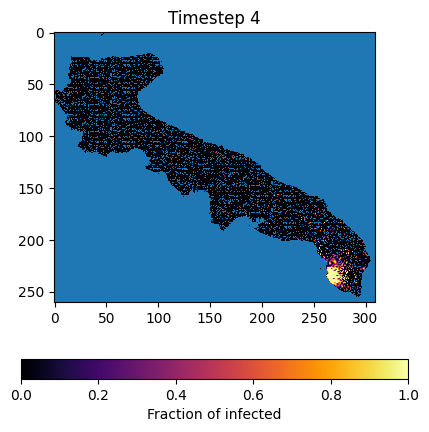

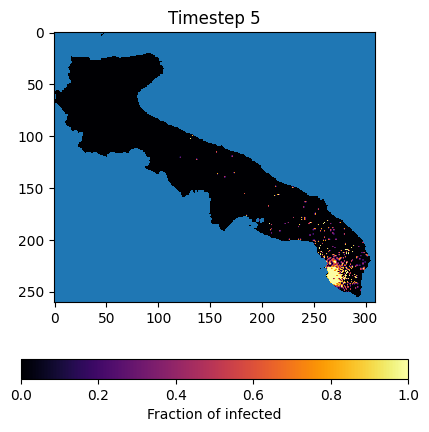

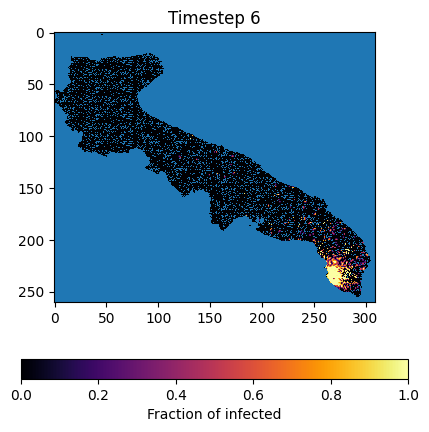

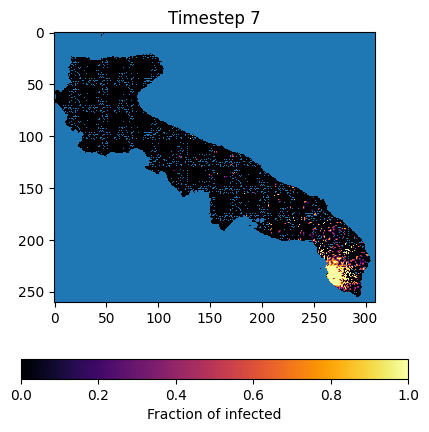

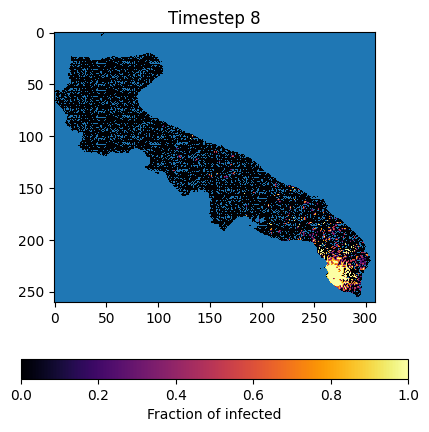

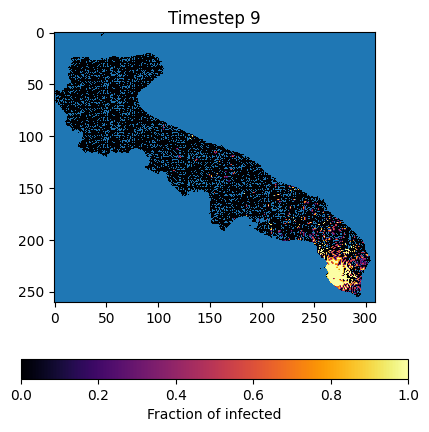

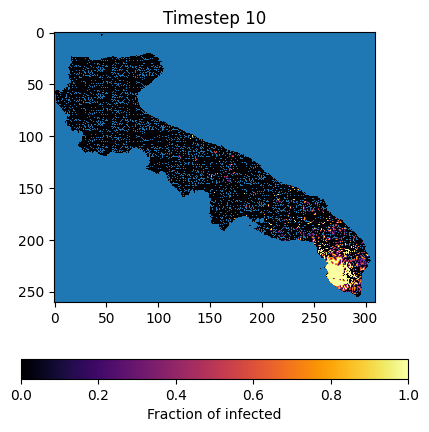

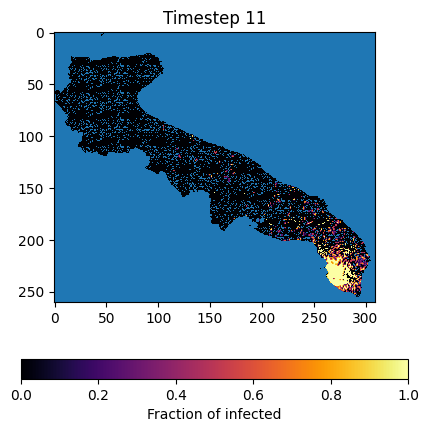

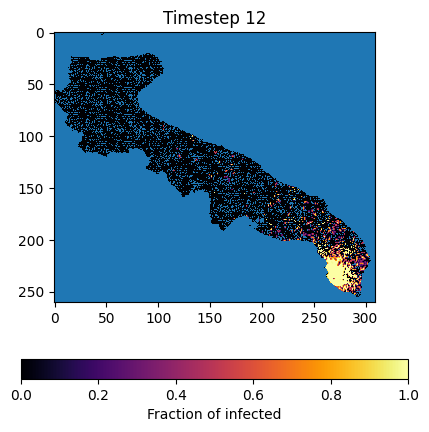

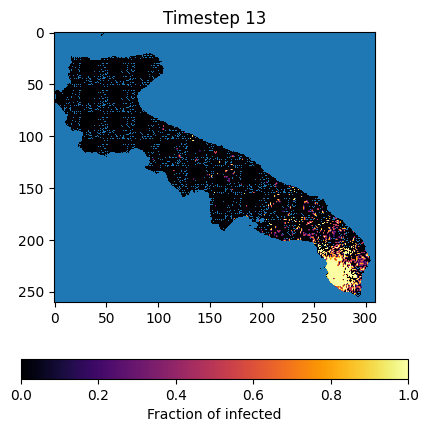

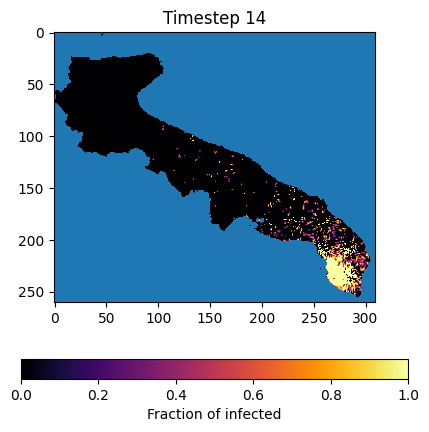

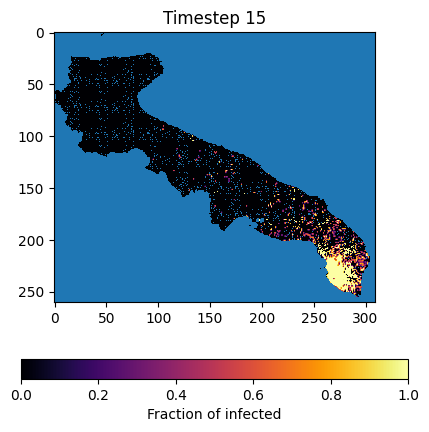

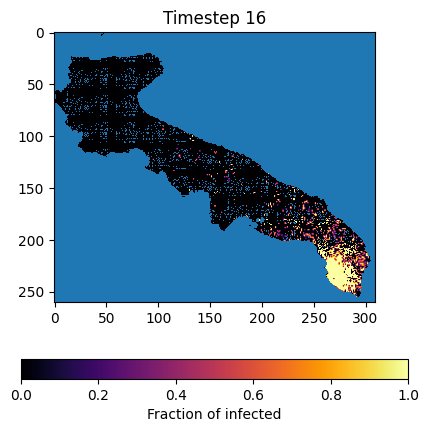

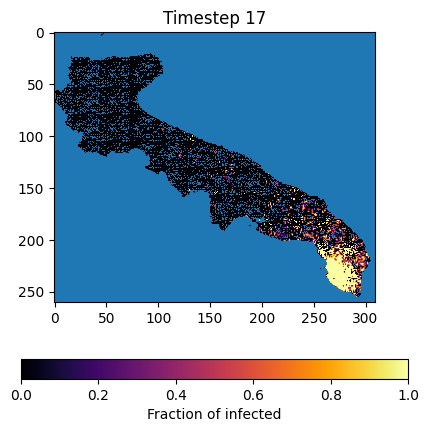

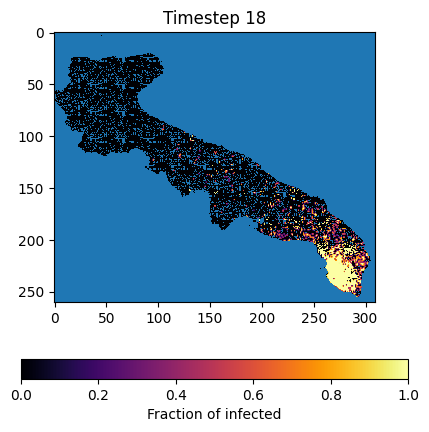

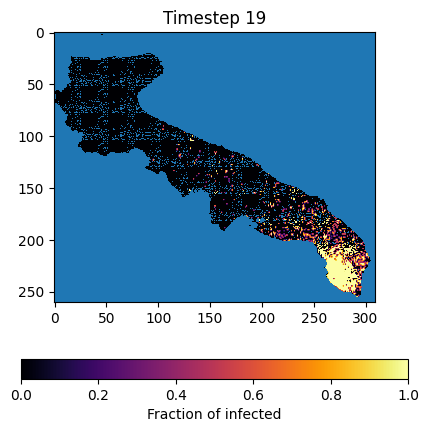

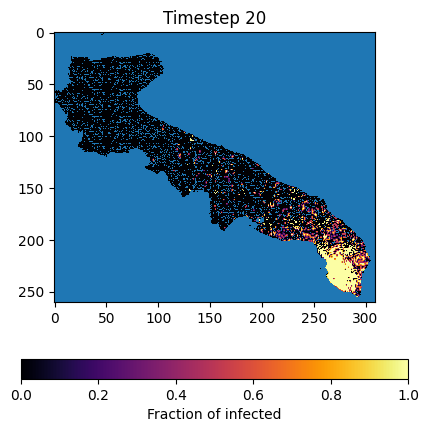

In [119]:
# SIMULATE DIFFUSION

SHORT_LONG = False
LEVY_FLIGHT = True

np.random.seed(1222)

time_steps = 20

output = np.zeros((time_steps+1, H, W)) # Final fraction of infected after every year
U = np.zeros((H, W)) # Fraction of infected at every timestep

# Set initial conditions
if FROM_DATA:
    seed = np.array([235,266]) # Initial spread from Gallipoli
else:
    grove_coordinates = np.argwhere(grove_mask)
    seed = grove_coordinates[np.random.choice(grove_coordinates.shape[0])] # Random seed

U[tuple(seed)] = K[tuple(seed)] * np.exp(-B)

if LEVY_FLIGHT:
    vector_positions = np.full((n_vectors,2), seed, dtype=int)

# Attributes for plot
cmap_inferno = mpl.colormaps["inferno"]
cmap_inferno.set_under("tab:blue")

# initiate evolution
for t in range(output.shape[0]):
    if t > 0:
        # Local growth
        U = Gompertz_local_growth(U, K, A)
        adjust_population(U, no_grove_mask, tol)

        # Levy flight dispersal
        if LEVY_FLIGHT:
            U = levy_flight_dispersal(U, B, n_vectors, vector_positions, params, d_min=d_min, sample=SAMPLE)
            adjust_population(U, no_grove_mask, tol)

        if SHORT_LONG:
            # Short distance dispersal
            U = short_distance_dispersal(U, k)
            adjust_population(U, no_grove_mask, tol)
            
            # Long distance dispersal
            U = long_distance_dispersal(U, disp_tol, M_max, D, B)
            adjust_population(U, no_grove_mask, tol)

    # Obtain output
    output[t][grove_mask] = U[grove_mask] / olive_prop[grove_mask]
    output[t][sea_mask] = -9999
    output[t][no_grove_mask] = 0

    # Plot output for all times starting at 0
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f"Timestep {t}")
    im = ax.imshow(output[t], cmap=cmap_inferno, norm=norm)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal")
    cbar.set_label("Fraction of infected")
    plt.show()

In [ ]:
# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
# import pandas as pd

# data2022 = pd.read_csv("Data/CAMP_2022.csv", encoding='latin-1') # , skiprows=
# # pd.DataFrame(pd.read_excel("Data/CAMP_2022.xlsx"))

# # read_file = pd.read_excel("Data/CAMP_2022.xlsx") 
# # read_file.to_csv ("Data/CAMP_2022.csv",
# #                   index = None, 
# #                   header=True) 
# # data2022 = pd.DataFrame(pd.read_csv("Data/CAMP_2022.csv")) 

# display(data2022.head())

# # Extract latitude and longitude
# latitudes = data2022["LATITUDINE"].values
# longitudes = data2022["LONGITUDINE"].values


In [ ]:
# TODO: gather all datas from yearly monitoring campaigns and do timeseries/animation of yearly advancement. 
# Just plot to see if there are holes in the continuation of the disease or if we are able to make an accurate map of the evolution

# # Create a figure and a basemap
# # lower_left = [40.5, 16.8]
# # upper_right = [41.0, 17.5]

# plt.figure(figsize=(10, 10))
# m = Basemap(projection='merc',
#             llcrnrlat=min(latitudes)-0.1, urcrnrlat=max(latitudes)+0.1,
#             llcrnrlon=min(longitudes)-0.1, urcrnrlon=max(longitudes)+0.1,
#             resolution='i') # c (crude), l (low), i (intermediate), h (high), f (full)

# # Draw coastlines and countries for context
# m.drawcoastlines()
# m.drawcountries()

# # Convert lat/long to map projection coordinates
# x, y = m(longitudes, latitudes)

# # Plot the points
# m.scatter(x, y, marker='o', color='red', s=0.1)

# # Title and show the plot
# plt.title('Tree Locations on Basemap')
# plt.show()


In [ ]:
# ax.plot((xp1, xp2), (yp1, yp2), 'ro-', linewidth=1) # infection line

# x_erad1 = xp1 - 2
# x_erad2 = xp2 - 4
# y_erad1 = A1 * x_erad1 + B2_erad
# y_erad2 = A1 * x_erad2 + B2_erad
# ax.plot((x_erad1, x_erad2), (y_erad1, y_erad2), 'bo-', linewidth=1) # eradication line (eradication zone limit)

# x_rog1 = xp1 - 5
# x_rog2 = xp2 - 9
# y_rog1 = A1 * x_rog1 + B2_rog
# y_rog2 = A1 * x_rog2 + B2_rog
# ax.plot((x_rog1, x_rog2), (y_rog1, y_rog2), 'bo-', linewidth=1) # roguing line (buffer zone limit)

In [ ]:
# np.random.seed(1023)

# U_ = np.random.random(size=[H,W])
# U_[U_ < 0.99] = 0
# U_[sea_mask] = -9999

# cmap_inferno = mpl.colormaps["inferno"]
# cmap_inferno.set_under("tab:blue")

# fig, ax = plt.subplots()
# im = ax.imshow(U_, norm=norm, cmap=cmap_inferno)
# fig.colorbar(im, ax=ax)
# plt.show()

# prob_disp = np.random.random(size=[H,W]) * U_
# disp_cells = np.argwhere(prob_disp > disp_tol)
# rnd_disp = np.random.randint(1, M_max+1, size=len(disp_cells))
# print(f"Disperding cells and dispersers per cell: {[(tuple(disp_cell), n_disp) for disp_cell, n_disp in zip(disp_cells, rnd_disp)]}")

# for disp_cell, n_disp in zip(disp_cells, rnd_disp):
#     print(f"\nDisperding cell: {disp_cell}; and dispersers per cell: {n_disp}")
#     for i_disp in range(n_disp):
#         print(f"    Disperser {i_disp+1}")
#         i = 0
#         while True:
#             i += 1
#             new_cell = disp_cell + np.array([int(np.floor(dist)) for dist in np.random.normal(0,D, size=2)])
#             print(f"        Iteration {i}, new cell: {new_cell}")
#             if np.any(new_cell < 0) or np.any(np.array([H,W] - new_cell < 0)):
#                 print("        RETRY, Outside grid")
#                 continue
#             elif np.array_equal(new_cell, disp_cell):
#                 print("        RETRY, Same cell")
#                 continue
#             elif sea_mask[tuple(new_cell)]:
#                 print("        RETRY, Sea")
#                 continue
#             elif no_grove_mask[tuple(new_cell)]:
#                 print("        No groves, disperser is lost")
#                 break
#             else:
#                 print(f"        Cell ok, dispersal in: {new_cell}")
#                 U_[tuple(new_cell)] += 0.3 # np.exp(-B)
#                 break
            
# fig, ax = plt.subplots()
# im = ax.imshow(U_, norm=norm, cmap=cmap_inferno)
# fig.colorbar(im, ax=ax)
# plt.show()

In [ ]:
    # # Long distance dispersal
    # prob_disp = np.random.random(size=[H,W]) * U[t+1]
    # disp_cells = np.argwhere(prob_disp > disp_tol)
    # rnd_disp = np.random.randint(1, M_max+1, size=len(disp_cells))
    # # print(f"Disperding cells and dispersers per cell (Timestep {t+1}): {[(tuple(disp_cell), n_disp) for disp_cell, n_disp in zip(disp_cells, rnd_disp)]}")

    # for disp_cell, n_disp in zip(disp_cells, rnd_disp):
    #     # print(f"\nDispersing cell: {disp_cell}; and dispersers per cell: {n_disp}")
    #     for i_disp in range(n_disp):
    #         # print(f"    Disperser {i_disp+1}")
    #         i = 0
    #         while True:
    #             i += 1
    #             new_cell = disp_cell + np.array([int(np.floor(dist)) for dist in np.random.normal(0,D, size=2)])
    #             # print(f"        Iteration {i}, new cell: {new_cell}")
    #             if np.any(new_cell < 0) or np.any(np.array([H,W] - new_cell <= 0)):
    #                 # print("        RETRY, Outside grid")
    #                 continue
    #             elif np.array_equal(new_cell, disp_cell):
    #                 # print("        RETRY, Same cell")
    #                 continue
    #             elif sea_mask[tuple(new_cell)]:
    #                 # print("        RETRY, Sea")
    #                 continue
    #             elif no_grove_mask[tuple(new_cell)]:
    #                 # print("        No groves, disperser is lost")
    #                 break
    #             else:
    #                 # print(f"        Cell ok, dispersal in: {new_cell}")
    #                 U[t+1][tuple(new_cell)] += (1 - U[t+1][tuple(new_cell)]) * np.exp(-B) # Added the 1-U part to say that the remaining susceptible are infected with probability exp(-B) 
    #                 break

In [ ]:
# np.random.seed(189)

# # Implement a Levy flight random walk for vectors.

# # Initialize vector positions (more than one vector can be in the same cell at the same time)
# vector_positions = np.random.randint(np.zeros(n_vectors), [[H],[W]]).T
# grid = np.zeros((H,W))
# for pos in vector_positions:
#     grid[tuple(pos)] += 1
# # print(grid)
# mask = grid > 0

# fig, ax = plt.subplots()
# im = ax.imshow(mask)
# plt.show()

# for t in range(10):
#     # Generate Levy flight random steps
#     u_list = np.random.uniform(size=n_vectors)
#     d_list = (1 - u_list)**(1 / (1 - mu)) * d_min # step size sampled from a power law distribution
#     for i, vector_pos, d in zip(range(n_vectors), vector_positions, d_list):
#         while True:
#             theta = np.random.uniform() * 2 * np.pi # random uniform direction
#             step_coord = np.rint(np.array([np.sin(theta), np.cos(theta)])).astype(np.int32)
#             # print(step_coord)
#             new_vector_pos = vector_pos + step_coord
#             if np.any(new_vector_pos < 0) or np.any(np.array(np.array([H,W]) - new_vector_pos <= 0)):  continue # Outside grid
#             elif sea_mask[tuple(new_vector_pos)]:                                               continue # Sea
#             elif np.array_equal(new_vector_pos, vector_pos):                                    break    # Same cell, OK
#             elif no_grove_mask[tuple(new_vector_pos)]:                                          break    # No grove, OK
#             else:
#             #     U_[tuple(new_vector_pos)] += (1 - U_[tuple(new_vector_pos)]) * np.exp(-B) # Added the 1-U part to say that the remaining susceptible are infected with probability exp(-B) 
#                 break    # OK
#         vector_positions[i] = new_vector_pos
    
#     grid = np.zeros((H,W))
#     for pos in vector_positions:
#         grid[tuple(pos)] += 1
#     mask = grid > 0

#     fig, ax = plt.subplots()
#     im = ax.imshow(mask)
#     plt.show()


In [ ]:
# Sample from power law with exponential cutoff
# import scipy.integrate as integrate

# def p_target(x, alpha, mu): # target distribution support is [x_min, inf]
#     return x**(-alpha) * np.exp(-mu * x)

# def q_proposal(x, eta):
#     return eta * np.exp(-eta * x)

# def sample_power_law(size, x_min, x_max, scale, alpha, mu, eta):
#     global x_linspace
#     x_linspace = np.linspace(x_min, x_max, 10000)
#     M = np.max(p_target(x_linspace, alpha, mu) / q_proposal(x_linspace, eta)) # Max is obtained at infinity, so in this case at x=2
    
#     # xs = np.random.exponential(scale=1/eta, size=size) + x_min # sample from proposal distribution between x_min and inf
#     # us = np.random.uniform(0, 1, size=size)
#     # mask = p_target(xs, alpha, mu) / (M * q_proposal(xs, eta)) > us
#     # x = xs[mask]

#     u = np.random.random(size=size)
    
#     x = []
#     i = 0
#     while len(x) < size:
#         x_proposal = np.random.exponential(scale=1/eta) + x_min # sample from proposal distribution between x_min and inf
#         print(u[i])
#         if p_target(x_proposal, alpha, mu) / (M * q_proposal(x_proposal, eta)) > u[i]:
#             x.append(x_proposal)
#             print(i)
#             i += 1
#     x = np.array(x)
    
#     return x * scale

# size = 500 # n_vectors
# x_min = 0.1
# x_max = 2
# scale = 1
# alpha = 2
# mu = 1
# eta = 5

# Z_p, _ = integrate.quad(p_target, x_min, np.inf, args=(alpha, mu)) # calculate normalization constant between x_min and inf


# samples = sample_power_law(size, x_min, x_max, scale, alpha, mu, eta)
# print(len(samples)/size)
# fig, ax = plt.subplots()
# ax.plot(x_linspace, p_target(x_linspace, alpha, mu) / Z_p, label=r"$p(x)$")
# ax.hist(samples, bins=200, density=True, label="Sample")
# # plt.yscale("log")
# plt.xlim(0, 2 * scale)
# plt.legend()
# plt.show()